In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns

In [2]:
from sklearn import ensemble

In [3]:
train = pd.read_csv('price_data_tr.csv')
val = pd.read_csv('price_data_val.csv')
test = pd.read_csv('price_data_ts.csv')

In [4]:
# KEEPING A COPY OF TRAIN AND TEST DB FOR FURTHER USAGE
rawTrain = train.copy()
rawTest = test.copy()
rawVal = val.copy()

In [36]:
train.head(3)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,1310440590,20150413T000000,440000.0,3,2.50,2290,6302,2.0,0,0,...,9,2290,0,1997,0,98058,47.4350,-122.107,2700,7500
1,1437580480,20140918T000000,994000.0,5,3.25,4260,7861,2.0,0,0,...,10,4260,0,2005,0,98074,47.6110,-121.992,4020,7528
2,7617500075,20140721T000000,427000.0,3,1.75,2000,7111,1.0,0,0,...,7,1360,640,1956,0,98177,47.7676,-122.373,1830,9000


In [37]:
#breaking the date into yr, mm, day
train['date']=pd.to_datetime(train['date'])
train['month'] = train['date'].apply(lambda date:date.month)
train['year'] = train['date'].apply(lambda date:date.year)

test['date']=pd.to_datetime(test['date'])
test['month'] = test['date'].apply(lambda date:date.month)
test['year'] =test['date'].apply(lambda date:date.year)

val['date']=pd.to_datetime(val['date'])
val['month'] = val['date'].apply(lambda date:date.month)
val['year'] = val['date'].apply(lambda date:date.year)

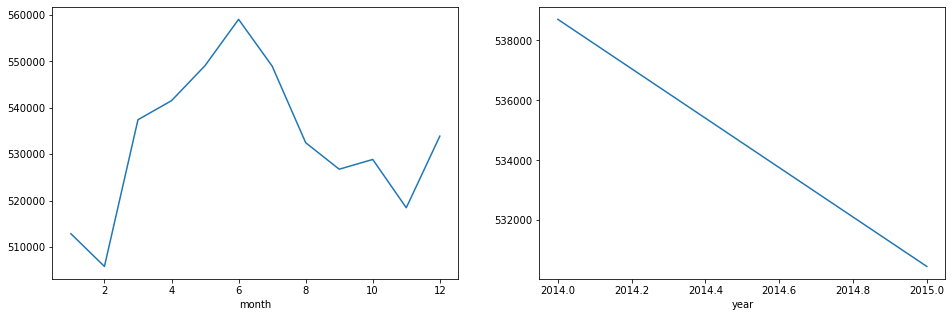

In [38]:
#data visualization house price vs months and years
fig = plt.figure(figsize=(16,5))
fig.add_subplot(1,2,1)
train.groupby('month').mean()['price'].plot()
fig.add_subplot(1,2,2)
train.groupby('year').mean()['price'].plot()

In [39]:
train = train.drop(['id', 'date'], axis=1)
val = val.drop(['id', 'date'], axis=1)
test = test.drop(['id','date'], axis=1)

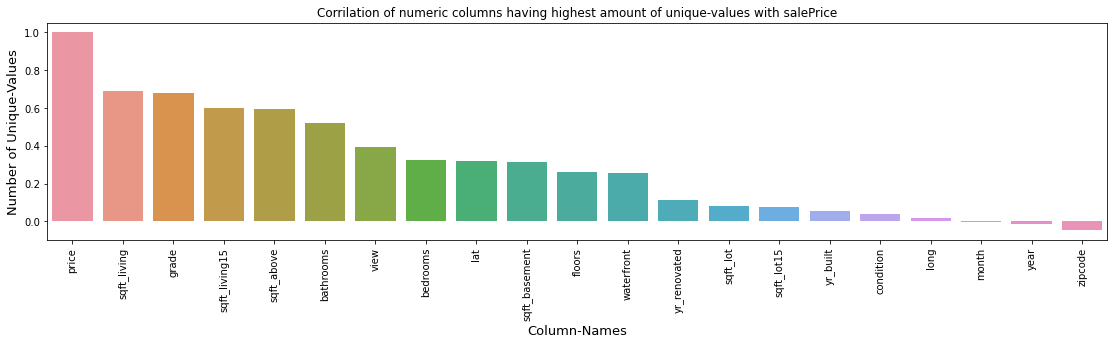

In [40]:
# CHECKING CORRELATION OF THE SELECTED COLUMNS WITH SALEPRICE
#highly_unique_columns = numeric_column_list.drop(numeric_column_list[numeric_column_list['Unique-Values'] < 65].index)
#droping columns with unique values less than 65

#cols = highly_unique_columns['Column-Names']
cols = train.columns.values.tolist()
corrs=[]
for item in cols:
    corrs.append((train[item].corr(train['price'])))    # .corr is for finding correlation coefficient
    
    '''
    Pandas dataframe.corr() is used to find the pairwise correlation of all columns in the dataframe. 
    Any na values are automatically excluded. For any non-numeric data type columns in the dataframe it is ignored.
    '''
    
# MAKING A DATAFRAME TO STORE THE CORRELATIONS     
ist = pd.DataFrame(
    {'cols': cols,
     'corrs': corrs
    })
ist = ist.sort_values(by='corrs', ascending=False)

# VISUALIZING CORRELATIONS GRAPHICALLY
plt.subplots(figsize=(19, 4))
sns.barplot(x=ist['cols'], y=ist['corrs'])
plt.xticks(rotation=90)
plt.ylabel('Number of Unique-Values', fontsize=13)
plt.xlabel('Column-Names', fontsize=13)
plt.title('Corrilation of numeric columns having highest amount of unique-values with salePrice')
plt.show()

In [41]:

train_y = train['price']
train_x = train.drop(['price'], axis=1)

test_y = test['price']
test_x = test.drop(['price'], axis=1)

val_y = val['price']
val_x = val.drop(['price'], axis=1)

In [42]:
#standardization scaler - fit&transform on train, test, val
from sklearn.preprocessing import StandardScaler
s_scaler = StandardScaler()
train_x = s_scaler.fit_transform(train_x.astype(np.float))
val_x = s_scaler.transform(val_x.astype(np.float))
test_x = s_scaler.transform(test_x.astype(np.float))

In [43]:
#model selsction and evaluation
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()  
regressor.fit(train_x, train_y)

regressor.score(val_x, val_y)

0.7168794138593431

In [44]:
y_pred = regressor.predict(val_x)

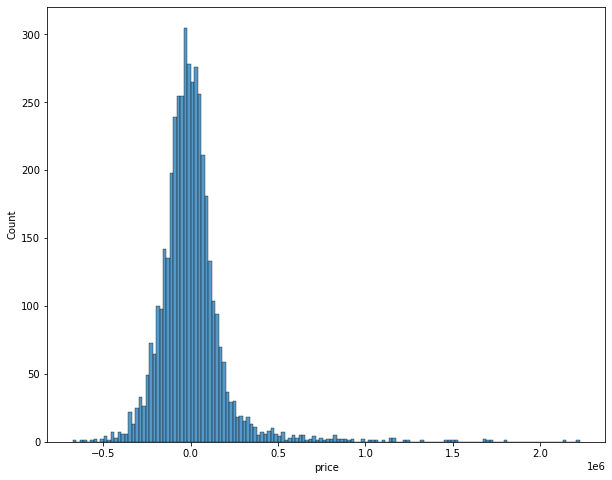

In [45]:
# visualizing residuals
fig = plt.figure(figsize=(10,8))
residuals = (val_y - y_pred)
sns.histplot(residuals)

In [53]:
# this one is best prediction
clf = ensemble.GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                         min_samples_split=5, 
                                   loss='squared_error', random_state =18)
clf.fit(train_x, train_y)

#scores on validation set
clf.score(val_x, val_y)
#score here --> 0.9159325084237034

0.9118055132555635

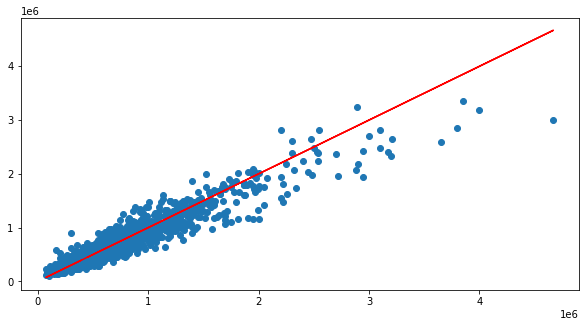

In [54]:
y_pred = clf.predict(val_x)
fig = plt.figure(figsize=(10,5))
plt.scatter(val_y, y_pred)
# Perfect predictions
plt.plot(val_y, val_y,'r')

In [51]:
'''
# Some other modification if parameters
clf = ensemble.GradientBoostingRegressor(n_estimators=5000, learning_rate=0.1,
                                   max_depth=5, max_features='sqrt',
                                         min_samples_split=5, 
                                   loss='squared_error', random_state =42)
clf.fit(train_x, train_y)

#scores on validation set
clf.score(val_x, val_y)
#score here --> 0.9011904985292363
'''

0.9011904985292363

In [47]:
#showing correct and incorrct prediction
pred = clf.predict(val_x)

correct_pred = []
incorrect_pred = []
c_count = 0
ic_count = 0
for i in range(len(rawVal['price'])):
    if (pred[i].round() == rawVal['price'][i]):
        correct_pred.append([pred[i].round(), rawVal['price'][i]])
        c_count += 1
    else:
        incorrect_pred.append([pred[i].round(), rawVal['price'][i]])
        ic_count +=1
print(f'correct pred: {c_count}')  
print(f'incorrect pred: {ic_count}')
print(f'correct prediction:\n', 'prediction--true price \n', pd.DataFrame(correct_pred))
print(f'incorrect prediction:\n', 'prediction--true price \n', pd.DataFrame(incorrect_pred))

correct pred: 0
incorrect pred: 4323
correct prediction:
 prediction--true price 
 Empty DataFrame
Columns: []
Index: []
incorrect prediction:
 prediction--true price 
              0         1
0     402122.0  453500.0
1     560399.0  510000.0
2     387789.0  379900.0
3     328182.0  340000.0
4     259299.0  273500.0
...        ...       ...
4318  262414.0  295000.0
4319  556544.0  625000.0
4320  460249.0  412500.0
4321  697378.0  595000.0
4322  414552.0  395000.0

[4323 rows x 2 columns]


In [ ]:
pred_y = clf.predict(test_x)
pred_y

In [ ]:
res_col = ['id', 'price']
res_df = pd.DataFrame(rawTest, columns=res_col)
res_df['id'], res_df['price'] = test_ID, pred_y
res_df['id']= res_df['id'].astype(str).str.zfill(10)
res_df['price']= res_df['price'].round()
res_df['id'] = res_df['id'].astype(str)+test_date.astype(str)
res_df.to_csv('resultGBoostRg3.csv', index=False)

# Improving

In [30]:
train = rawTrain.copy()
val = rawVal.copy()
test = rawTest.copy()

Number of Neumeric Columns =  20


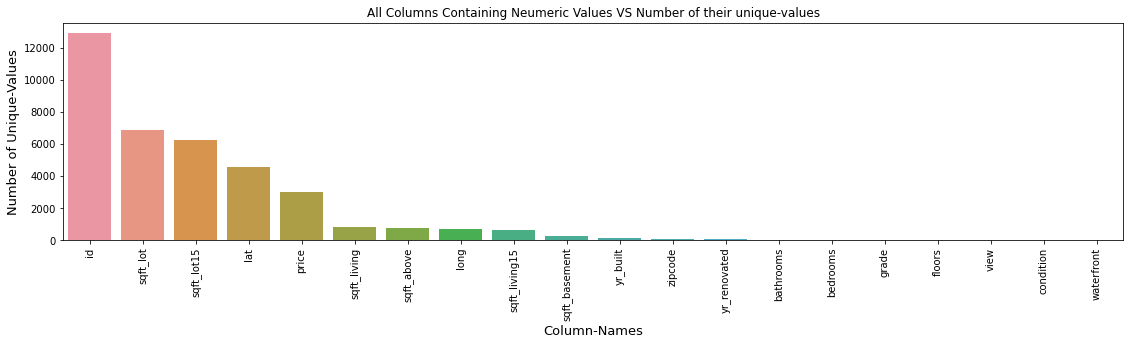

In [31]:
#finding unique values

# SEPARATING NUMERIC COLUMNS
numeric_columns = train.select_dtypes(exclude=['object']).columns.values.tolist()
#print(numeric_columns)
print('Number of Neumeric Columns = ',len(numeric_columns))
unique_values=[]
for item in numeric_columns: 
    unique_values.append(train[item].nunique())
numeric_column_list = list(zip(numeric_columns, unique_values))
#(numeric_column_list)
numeric_column_list = sorted(numeric_column_list,key=lambda l:l[1], reverse=True)
numeric_column_list=pd.DataFrame(numeric_column_list, columns=['Column-Names', 'Unique-Values'])
                                                  
                                                  # PLOTTING NUMBER OF UNIQUE-VALUES FOR EACH NUMERIC COLUMNS
plt.subplots(figsize=(19, 4))
sns.barplot(x=numeric_column_list['Column-Names'], y=numeric_column_list['Unique-Values'])
plt.xticks(rotation=90)
plt.ylabel('Number of Unique-Values', fontsize=13)
plt.xlabel('Column-Names', fontsize=13)
plt.title('All Columns Containing Neumeric Values VS Number of their unique-values')
plt.show()

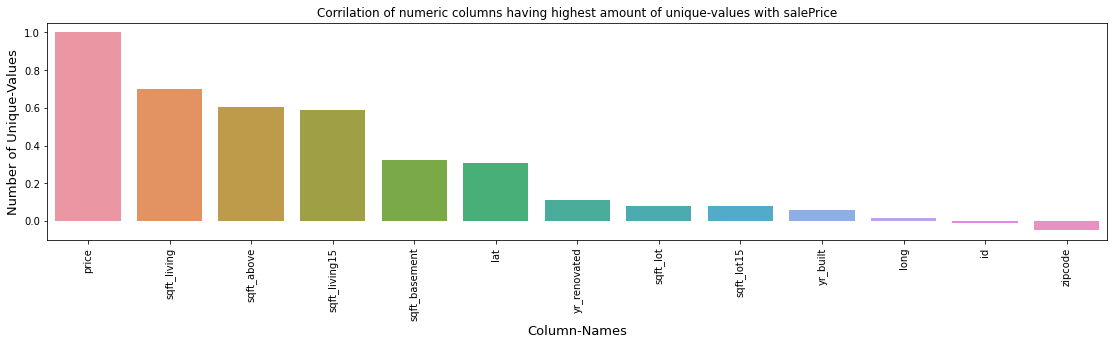

In [32]:
# CHECKING CORRELATION OF THE SELECTED COLUMNS WITH SALEPRICE
highly_unique_columns = numeric_column_list.drop(numeric_column_list[numeric_column_list['Unique-Values'] < 65].index)
#droping columns with unique values less than 65

cols = highly_unique_columns['Column-Names']
corrs=[]
for item in cols:
    corrs.append((train[item].corr(train['price'])))    # .corr is for finding correlation coefficient
    
    '''
    Pandas dataframe.corr() is used to find the pairwise correlation of all columns in the dataframe. 
    Any na values are automatically excluded. For any non-numeric data type columns in the dataframe it is ignored.
    '''
    
# MAKING A DATAFRAME TO STORE THE CORRELATIONS     
ist = pd.DataFrame(
    {'cols': cols,
     'corrs': corrs
    })
ist = ist.sort_values(by='corrs', ascending=False)

# VISUALIZING CORRELATIONS GRAPHICALLY
plt.subplots(figsize=(19, 4))
sns.barplot(x=ist['cols'], y=ist['corrs'])
plt.xticks(rotation=90)
plt.ylabel('Number of Unique-Values', fontsize=13)
plt.xlabel('Column-Names', fontsize=13)
plt.title('Corrilation of numeric columns having highest amount of unique-values with salePrice')
plt.show()

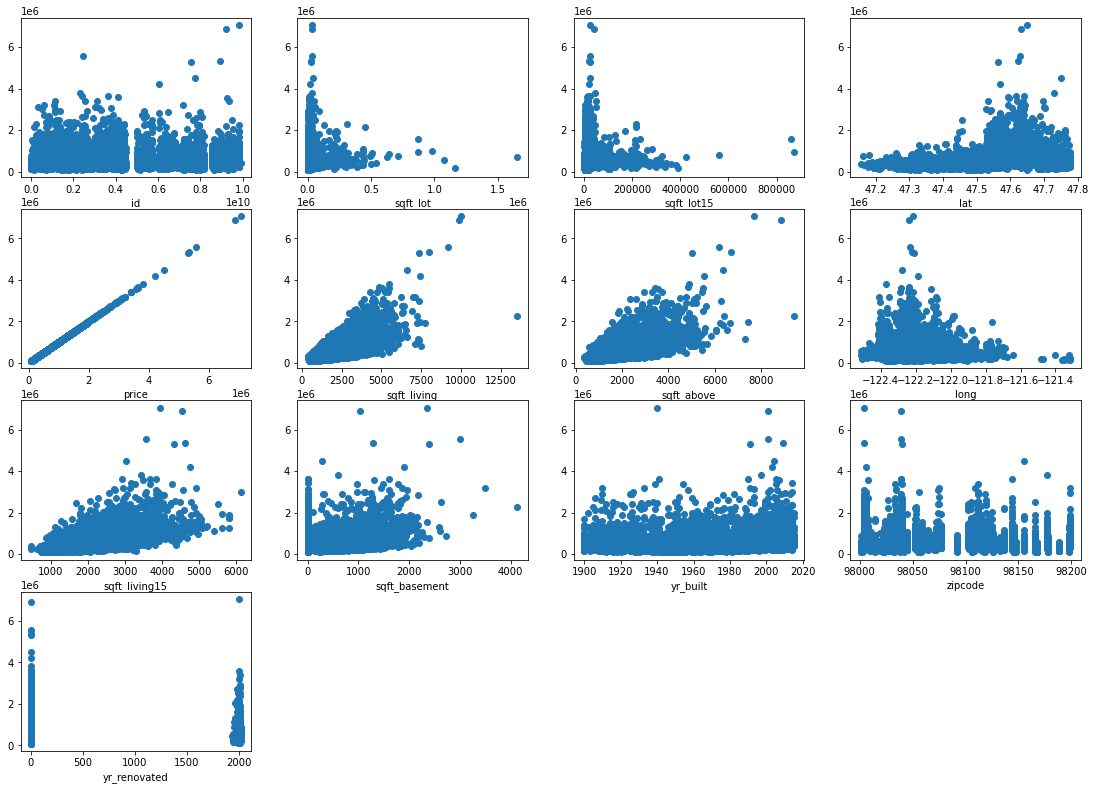

In [33]:
# cheking fo routliers

# a function to show relation with sales price
def relation_wid_price(c, column):
    plt.subplot(5, 4, c)
    plt.scatter(x=train[column], y=train['price'])
    plt.xlabel(column)
c=1
plt.subplots(figsize=(19, 17))
for item in cols:
    relation_wid_price(c, item)
    c = c+1
plt.show()

looks like price greater than 4e6 are introducing some outliers
we can remove those

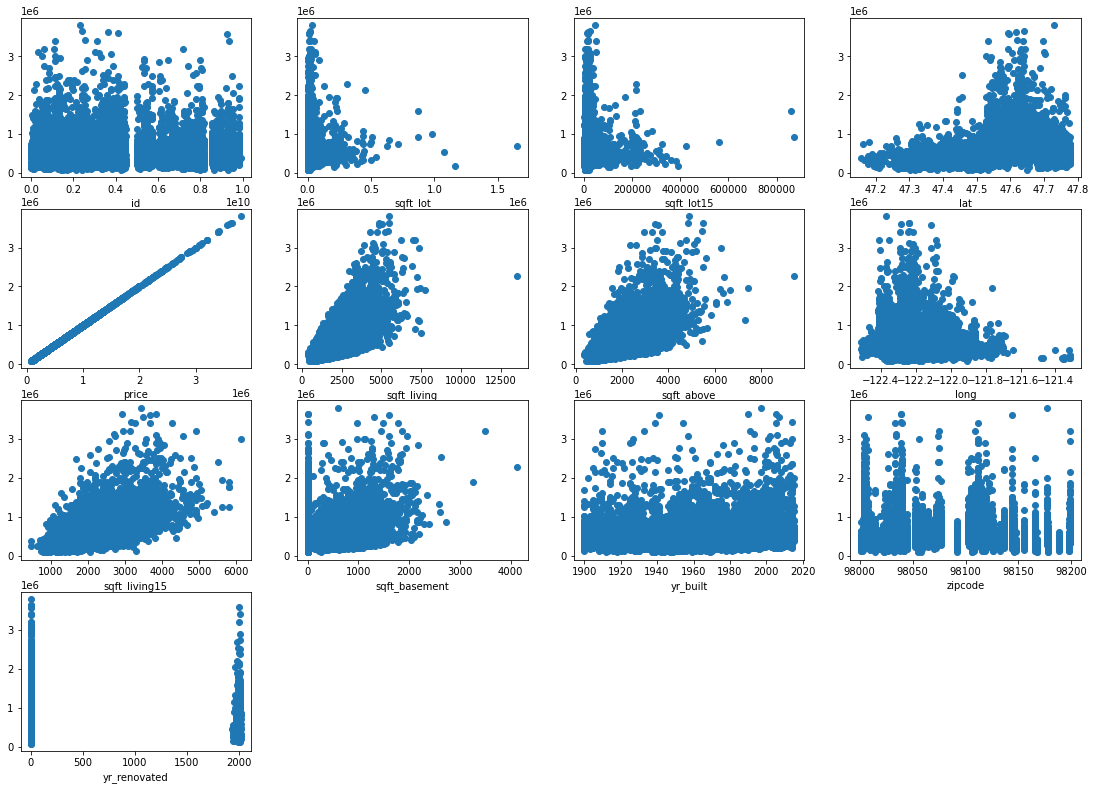

In [34]:
#price less than 4e6 looks providing better result
def relation_wid_price(c, column):
    plt.subplot(5, 4, c)
    plt.scatter(x=train[train['price']<4000000][column], y=train[train['price']<4000000]['price'])
    plt.xlabel(column)
c=1
plt.subplots(figsize=(19, 17))
for item in cols:
    relation_wid_price(c, item)
    c = c+1
plt.show()

In [35]:
#train = train.drop(train[(train['BsmtFinSF1']>2000) & (train['SalePrice']<500000)].index)
train = train[train['price']<4000000]

In [ ]:
train.describe()

# repeating the previous process of makinf train_x, train_y, test_x, tes_y......

In [ ]:
train.head()